# The Type of Player Contributes The Most Data To The PLAICraft Research

## Introduction To Our Project

In [2]:
library(tidyverse)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"

players <- read_csv(url)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
options(repr.plot.width = 8, repr.plot.height = 7)

players_wrangled <- players |>
                        select(- hashedEmail, - individualId, - organizationName) |>
                        group_by(experience) |>
                        filter(played_hours >= 0.1)

## Methods and Results

In [37]:
set.seed(1)

players_experience <- players_wrangled |>
    select(experience, age, played_hours) # Dataframe for Experience Classification


experience_split <- initial_split(players_experience, prop = 0.75, strata = experience) 
# Creates a 25/75 split into training data and validation data
experience_subtrain <- training(experience_split)
experience_test <- testing(experience_split)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

exp_training_recipe <- recipe(experience ~ age + played_hours, data = experience_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

exp_workflow <- workflow() |>
    add_recipe(exp_training_recipe) |>
    add_model(knn_spec) |>
    fit(data = experience_subtrain)

In [ ]:
experience_vfold <- vfold_cv(experience_train, v = 5, strata = experience)
experience_vfold

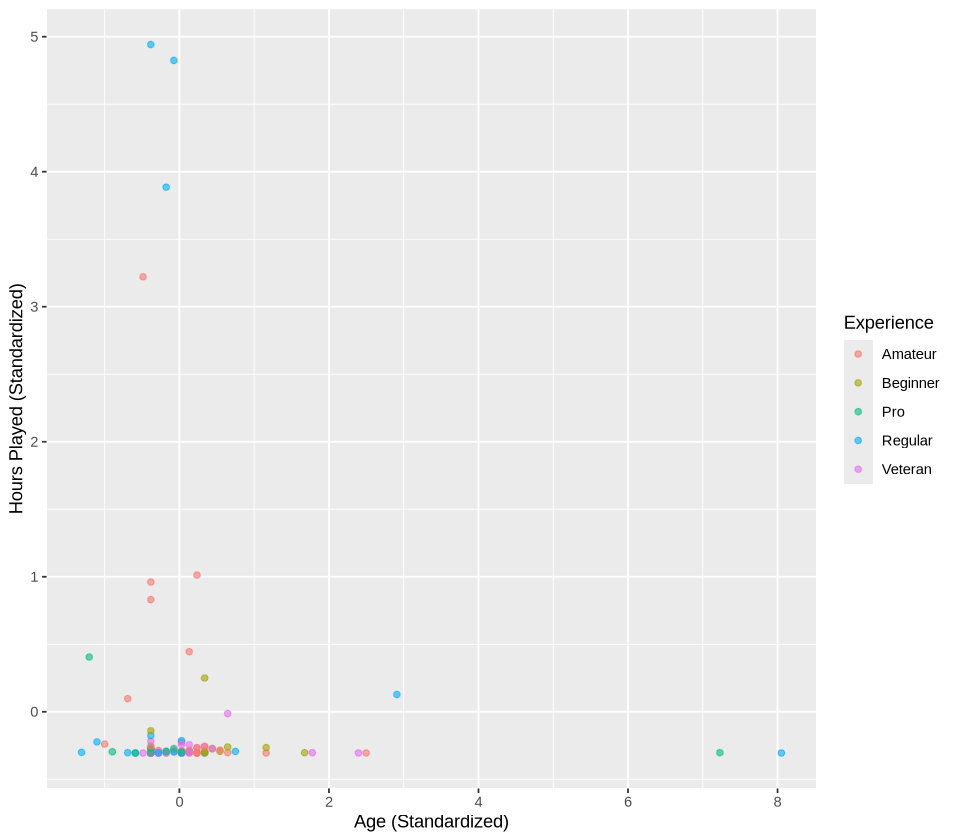

In [17]:
experience_recipe <- recipe(experience ~ age + played_hours, data = experience_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()

scaled_experience <- bake(experience_recipe, players_experience)

scaled_plot <- scaled_experience |>
    ggplot(aes(x = age, y = played_hours, color = experience)) +
    geom_point(alpha = 0.6) +
    labs(x = 'Age (Standardized)', y = 'Hours Played (Standardized)', color = 'Experience')
scaled_plot



In [39]:


exp_recipe <- recipe(experience ~ age + played_hours, data = experience_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_fit <- workflow() |>
  add_recipe(exp_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_experience)
knn_fit
new_observation <- tibble(age = c(100,23), played_hours = c(99, 111))
prediction <- predict(knn_fit, new_observation)

prediction

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Warning message:
“tune samples were requested but there were 111 rows in the data. 106 will be used.”


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(tune(),     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.6846847
Best kernel: rectangular
Best k: 106

.pred_class
<fct>
Amateur
Amateur
